# Probablilistic Finite State Automata

In [1]:
%matplotlib inline
import logging
logging.basicConfig(level=logging.INFO)

from numpy import *
from myutil import HtmlPlugin
from wfsa import WFSA, PFSA, Sample, csra_matrix, FileBatch

from contextlib import contextmanager
from time import time
Tests = (
  ('avglen',dict(
    title='Expected length',
    empirical=lambda X,start,sample: sum([sum(batch!=X.stop) for batch,_ in sample.content])/sample.size,
    theoretical=lambda X,start: X.expected_length(start),
  )),
  ('entropy',dict(
    title='Entropy',
    empirical=lambda X,start,sample: -mean(X.logproba(sample,start)),
    theoretical=lambda X,start: X.entropy(start),
  )),
)
@contextmanager
def ptime():
  t = time()
  try: yield; print(f' [{time()-t:.3g}s]')
  except NotImplementedError: print('Not implemented!')
  except: print('Error!'); raise
def test(X,nsample,start=0,**alt):
  print(f'Deterministic: {X.deterministic}')
  print('Producing sample of size',nsample,end='',flush=True)
  with ptime():
    sample = X.sample(nsample,start,store=FileBatch('samples',clear=True).store)
    print(f' on {len(sample.content)} batches',end='')
  try:
    for key,D in Tests:
      print(D['title'])
      print('\tempirical  : ',end='',flush=True)
      with ptime(): v = D['empirical'](X,start,sample); print(f'{v:.15g}',end='')
      print('\ttheoretical: ',end='',flush=True)
      with ptime(): v = D['theoretical'](X,start); print(f'{v:.15g}',end='')
      v = alt.get(key)
      if v is not None: print(f'\talternative: {v:.15g}')
  finally:
    print(f'Sample ({10}/{nsample})')
    sample.pprint(X.symb_names,10,translate={ord(X.symb_names[X.stop]):''})

## Basic example

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,F,O,A,B
F,1.0,,,
O,0.2,,0.3,0.5
A,,0.2,0.8,
B,,0.4,,0.6


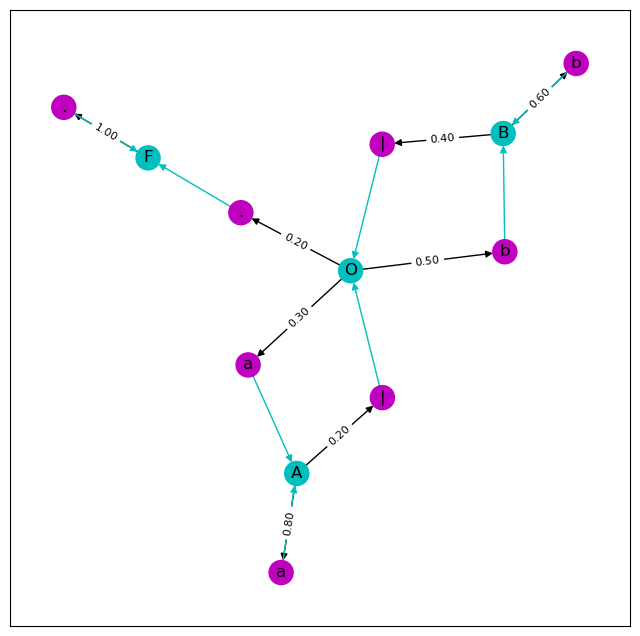

In [2]:
X = PFSA.from_str('''
F->F . 1.
O->A a .3
O->B b .5
O->F . .2
A->A a .8
A->O | .2
B->B b .6
B->O | .4
''')
X.draw(ax=dict(figsize=(8,8)))
X

Draw a large sample from state 'O'

In [3]:
test(X,100000,start='O')

Deterministic: True
Producing sample of size 100000 on 13 batches [0.341s]
Expected length
	empirical  : 17.70729 [0.004s]
	theoretical: 17.75 [2.15e-05s]
Entropy
	empirical  : 13.0855371399442 [0.62s]
	theoretical: 13.1076061656671 [0.000177s]
Sample (10/100000)
64328    11   b|b|b|aaaa|
 9921    45   bbb|b|aaaaaaa|aaaa|bb|bbb|aaaaa|bbb|bbbbbbbb|
24192    29   bbbbb|aaaa|a|aaaaaaa|aaaaaaa|
49480    15   bbbbbb|aaaaaaa|
41711     0   
73281     0   
30221    29   aaaaaaaaaaaa|bbbb|aaaa|b|bbb|
18022    30   aaaaa|aaaaaa|aaaaa|bb|aaaa|bb|
77909    12   bb|bbbbbb|b|
70830     5   a|bb|


## Another example with super easy entropy

Closed form of entropy: $\frac{-p\log p-q\log q}{q}$

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,F,O
F,1.0,
O,0.25,0.75


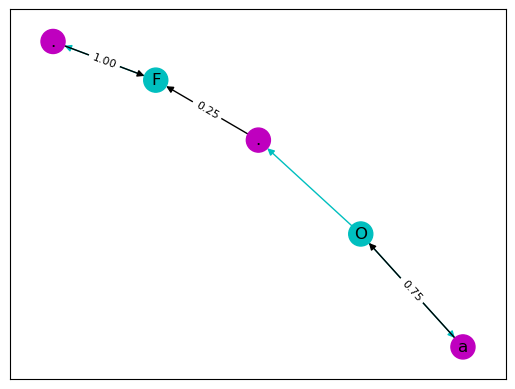

In [4]:
p = .75; q = 1.-p
X = PFSA.from_str(f'''
F->F . 1.
O->O a {p}
O->F . {q}
''')
X.draw(k=2,K=1)
X

In [5]:
test(X,100000,start='O',avglen=p/q,entropy=-(p*log(p)+q*log(q))/q)

Deterministic: True
Producing sample of size 100000 on 14 batches [0.0631s]
Expected length
	empirical  : 2.98872 [0.00113s]
	theoretical: 3 [4.91e-05s]
	alternative: 3
Entropy
	empirical  : 2.24609552469798 [0.0857s]
	theoretical: 2.24934057847523 [0.000247s]
	alternative: 2.24934057847523
Sample (10/100000)
70371    0   
44651    2   aa
92900    2   aa
52189    1   a
79637    2   aa
 6676    9   aaaaaaaaa
71982    1   a
44853    1   a
51335    0   
34231    3   aaa


## Other example with sparse matrices

Closed form of entropy: $L(-p\log p-q\log q)$

In [6]:
p =.7; L = 100; q = 1.-p
W = [*(z*eye(L+1,k=1) for z in (p,q)),zeros((L+1,L+1))]
W[-1][-1,-1] = 1
W = [csra_matrix.initial(w) for w in W]
X = PFSA(W,symb_names=('a','b','.'))
X

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . 100


🛈


In [7]:
test(X,10000,start=0,avglen=L,entropy=-L*(p*log(p)+q*log(q)))

Deterministic: True
Producing sample of size 10000 on 1 batches [0.0799s]
Expected length
	empirical  : 100 [0.00196s]
	theoretical: 100 [3.46e-05s]
	alternative: 100
Entropy
	empirical  : 61.1387084834753 [7.29s]
	theoretical: 61.0864302054893 [0.00131s]
	alternative: 61.0864302054893
Sample (10/10000)
6131   100   aaaaabbaabaaaaabbaababbabaabbaaaabbaaaaaabaaaaaabababbabaaabaaabaababbaabaaaaaaaababaabbaaaabbabbbbb
5550   100   aaabbabbaaaababbbbaabababaaabaabaabbaabaaaaaaababaaaaaabaabbbabbabbaaaabaaaaabbabaaaaaababaaaaabaaba
6931   100   aaabbaaaaaaabaaaabaabbaababbbabbabaaaaabaaaaaabaabaaaaabbaabbabbbaabaaaabababaababaaaababaaaaaaaabba
7659   100   ababbaaabaaaaaabaaabaaabababaaaaaaaaabbbababaababaaaabaaaaaaabaaaaaaaaaabaaaabaaabaabaaaababbaaaaaba
9767   100   aaaaabaaaaaaaaaaabaaaaaaaabbbaabbbaaabaaaaaaaaaaabababaaabaaabbabaaaaaaaaaaaaabaaabaabaaaaabaaaaaaba
5653   100   ababaababbbaabbbaababaaaaaaabbaaaababbaabaababbaaaaabaabaabaaaaaaaaabbaaabaaaaaaabbaabaaaaabbaababba
5255   100 

## Pruning

In [8]:
X = WFSA.from_str('''
F->F . 1.
O->A a .3
O->B b .5
O->F . .2
A->A a .8
A->O | .2
B->B b .6
B->O | .4
U->V | 1
U->V a 1
U->V b 1
V->U | 1
V->U a 1
V->U b 1
U->W | 1
U->W a 1
U->W b 1
V->W | 1
V->W a 1
V->W b 1
W->W | 0
''')
X

🛈,F,O,A,B,U,V,W
F,1.0,,,,,,
O,0.2,,0.3,0.5,,,
A,,0.2,0.8,,,,
B,,0.4,,0.6,,,
U,,,,,,3.0,3.0
V,,,,,3.0,,3.0
W,,,,,,,


INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F
INFO:wfsa.probabilistic:Pruning unreachable states: 3/7


🛈,F,O,A,B
F,1.0,,,
O,0.2,,0.3,0.5
A,,0.2,0.8,
B,,0.4,,0.6


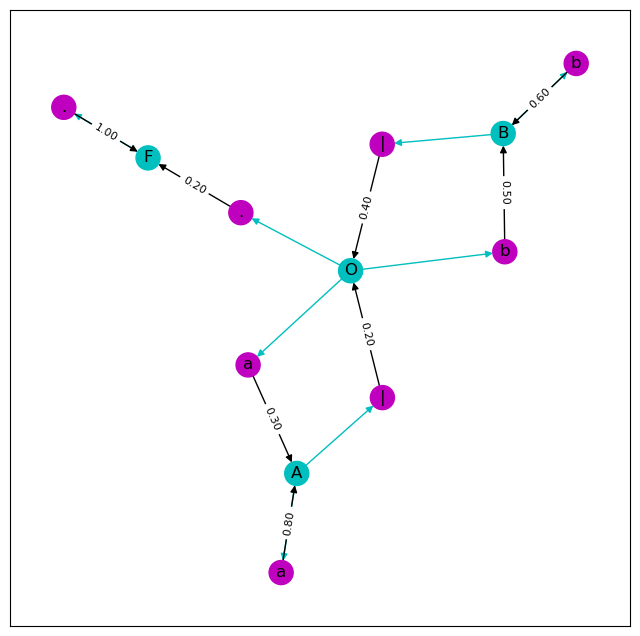

In [9]:
X = PFSA.fromWFSA(X)
X.draw(ax=dict(figsize=(8,8)))
X

## Intersection

In [2]:
L = 5
template,wstop = eye(L+1,k=1),zeros((L+1,L+1)); wstop[-1,-1] = 1.
template,wstop = map(csra_matrix.initial,(template,wstop))
X_len = WFSA([wstop],template=template,symb_names=('.',),state_names=[f'L{k}' for k in range(L,-1,-1)])

X_cnt = WFSA.from_str('''
O->O a 1.5
O->O b .5
O->O . 1
''',sparse=True)

X_mot = WFSA.from_str('''
O->A a 1
O->O b 1
A->F b 1
A->A a 1
F->F a 1
F->F b 1
F->F . 1
''',sparse=True)

X = X_cnt@X_mot@X_len
X

🛈,O.O.L5,O.O.L4,O.O.L3,O.O.L2,O.O.L1,O.O.L0,O.A.L5,O.A.L4,O.A.L3,O.A.L2,O.A.L1,O.A.L0,O.F.L5,O.F.L4,O.F.L3,O.F.L2,O.F.L1,O.F.L0
O.O.L5,,0.5,,,,,,1.5,,,,,,,,,,
O.O.L4,,,0.5,,,,,,1.5,,,,,,,,,
O.O.L3,,,,0.5,,,,,,1.5,,,,,,,,
O.O.L2,,,,,0.5,,,,,,1.5,,,,,,,
O.O.L1,,,,,,0.5,,,,,,1.5,,,,,,
O.O.L0,,,,,,,,,,,,,,,,,,
O.A.L5,,,,,,,,1.5,,,,,,0.5,,,,
O.A.L4,,,,,,,,,1.5,,,,,,0.5,,,
O.A.L3,,,,,,,,,,1.5,,,,,,0.5,,
O.A.L2,,,,,,,,,,,1.5,,,,,,0.5,


INFO:wfsa.probabilistic:Inferred stop symbol and final state: . O.F.L0
INFO:wfsa.probabilistic:Pruning unreachable states: 3/18
INFO:wfsa.probabilistic:Normaliser min: 0.5 max: 32.0
/local/tools/anaconda/202307/lib/python3.11/site-packages/networkx/drawing/layout.py:746: RuntimeWarning: divide by zero encountered in divide
  direction = np.einsum("ijk,ij->ijk", delta, 1 / (nodesep + np.eye(nNodes) * 1e-3))


🛈,O.O.L5,O.O.L4,O.O.L3,O.O.L2,O.A.L5,O.A.L4,O.A.L3,O.A.L2,O.A.L1,O.F.L5,O.F.L4,O.F.L3,O.F.L2,O.F.L1,O.F.L0
O.O.L5,,0.2,,,,0.8,,,,,,,,,
O.O.L4,,,0.18,,,,0.82,,,,,,,,
O.O.L3,,,,0.12,,,,0.88,,,,,,,
O.O.L2,,,,,,,,,1.0,,,,,,
O.A.L5,,,,,,0.67,,,,,0.33,,,,
O.A.L4,,,,,,,0.63,,,,,0.37,,,
O.A.L3,,,,,,,,0.57,,,,,0.43,,
O.A.L2,,,,,,,,,0.43,,,,,0.57,
O.A.L1,,,,,,,,,,,,,,,1.0
O.F.L5,,,,,,,,,,,1.0,,,,


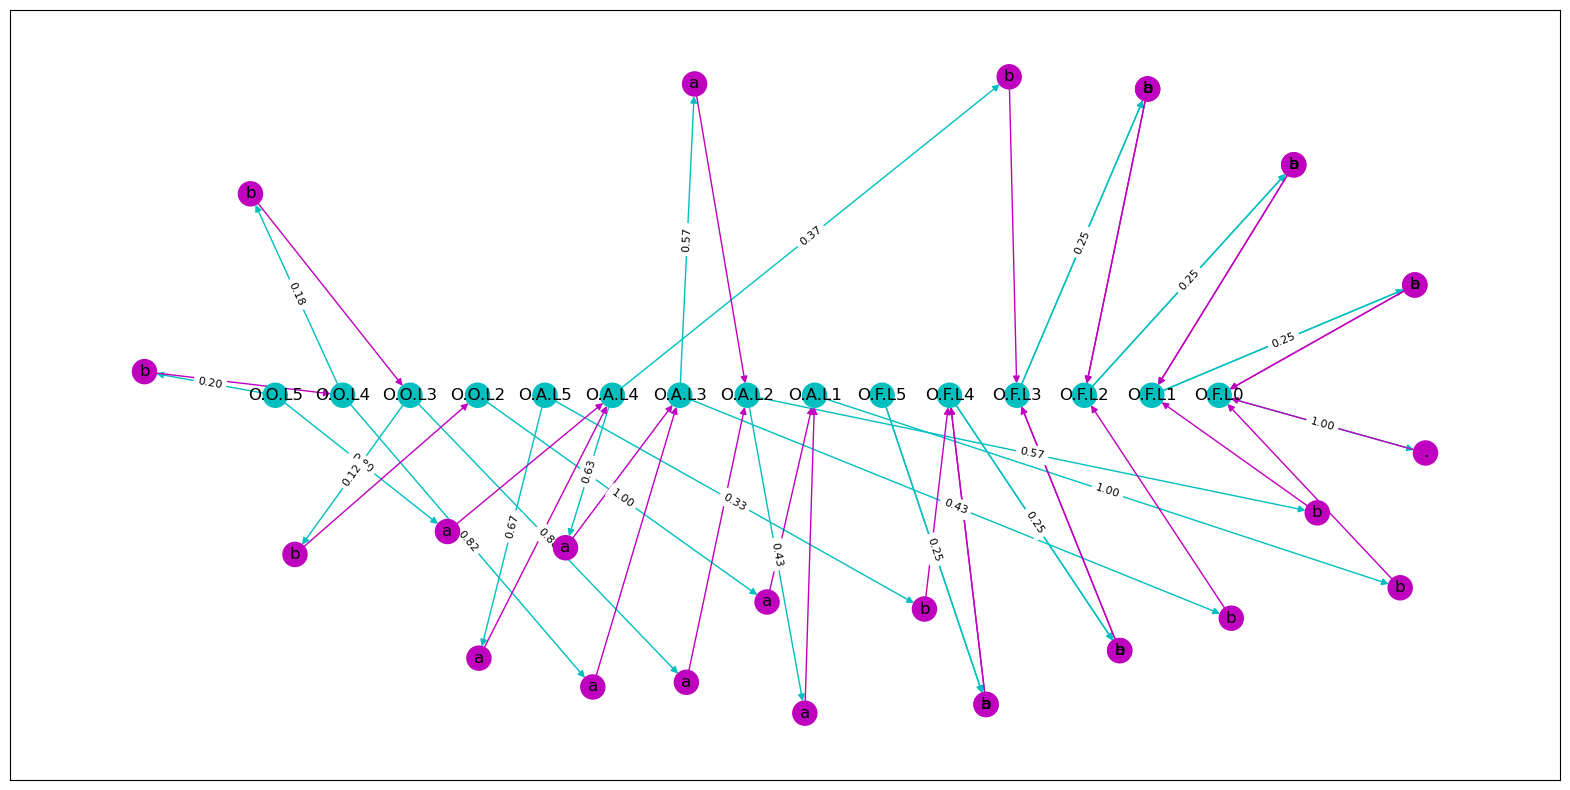

In [3]:
X = PFSA.fromWFSA(X)
X.draw(ax=dict(figsize=(20,10)),k=6.,weight=None) # some edges (pink nodes) overlap
X

In [12]:
def allstr(X,L):
  R = [c for c in range(X.n) if c!=X.stop]
  m = X.n-1
  sample = empty((L+1,Q),dtype=int)
  sample[L] = X.stop
  for k in range(L): sample[k] = tile(repeat(R,m**(L-1-k)),m**k)
  return sample
Q = (X.n-1)**L
sample = Sample(Q)
sample.append(allstr(X,L))
sample = sample.close()

P = exp(X.logproba(sample,start=0))
for x,p in zip(sample.values(),P): print(''.join(X.symb_names[c] for c in x),p)
print('Total probability:',sum(P))
print('Entropy:',X.entropy(start=0))

aaaaa. 0.0
aaaab. 0.12272727272727268
aaaba. 0.12272727272727274
aaabb. 0.040909090909090916
aabaa. 0.12272727272727274
aabab. 0.040909090909090916
aabba. 0.040909090909090916
aabbb. 0.013636363636363634
abaaa. 0.12272727272727274
abaab. 0.040909090909090916
ababa. 0.040909090909090916
ababb. 0.013636363636363634
abbaa. 0.040909090909090916
abbab. 0.013636363636363634
abbba. 0.013636363636363634
abbbb. 0.0045454545454545435
baaaa. 0.0
baaab. 0.040909090909090916
baaba. 0.040909090909090916
baabb. 0.013636363636363634
babaa. 0.040909090909090916
babab. 0.013636363636363634
babba. 0.013636363636363634
babbb. 0.0045454545454545435
bbaaa. 0.0
bbaab. 0.013636363636363634
bbaba. 0.013636363636363634
bbabb. 0.0045454545454545435
bbbaa. 0.0
bbbab. 0.004545454545454548
bbbba. 0.0
bbbbb. 0.0
Total probability: 1.0
Entropy: 2.8318634368671782


## Entropy not computable

INFO:wfsa.probabilistic:Inferred stop symbol and final state: . F


🛈,F,O,B,A3,A2,A1,A0
F,1.0,,,,,,
O,0.15,,0.25,0.3,0.2,0.1,
B,,0.2,0.8,,,,
A3,,,,,1.0,,
A2,,,,,,1.0,
A1,,,,,,,1.0
A0,,1.0,,,,,


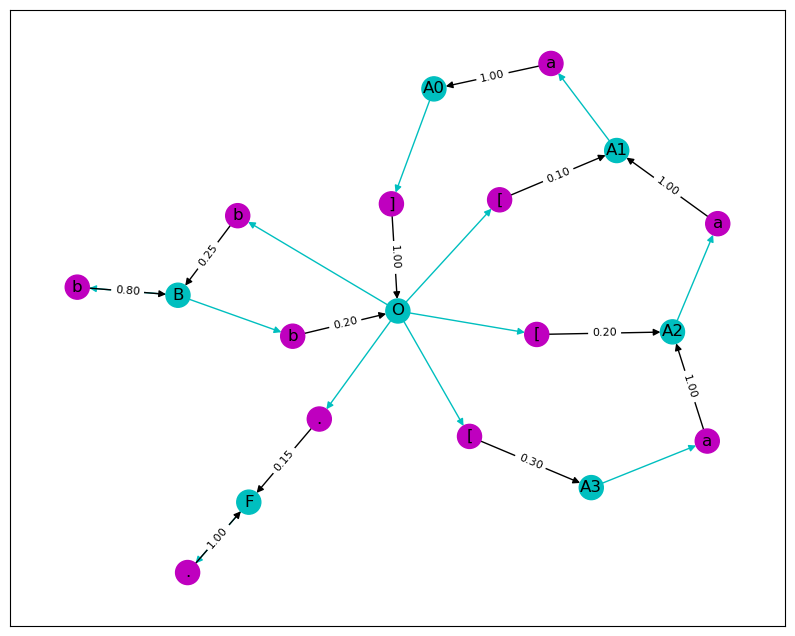

In [13]:
X = PFSA.from_str('''
F->F . 1.
O->A3 [ .3
O->A2 [ .2
O->A1 [ .1
O->B b .25
O->F . .15
B->B b .8
B->O b .2
A3->A2 a 1.
A2->A1 a 1.
A1->A0 a 1.
A0->O ] 1.
''')
X.draw(ax=dict(figsize=(10,8)),layout='kamada_kawai')
X

In [14]:
test(X,10000,start='O')

Deterministic: False
Producing sample of size 10000 on 10 batches [0.225s]
Expected length
	empirical  : 27.407 [0.00101s]
	theoretical: 27.3333333333333 [6.08e-05s]
Entropy
	empirical  : 12.9868702125977 [0.157s]
	theoretical: Not implemented!
Sample (10/10000)
6638     0   
6278     0   
 874    88   bbbbb[aa][aa][aaa][aaa][aaa][aaa][a]bbbbbbb[aa]bbbbbbbbbbbbbbbbbbbbbbbb[a][aa][aaa][aaa]
9469    13   bbb[aaa][a]bb
2910    54   [aa][aaa][a][aaa]bbbbbb[aaa][aaa][a]bbbbbbbbb[aa][aaa]
2898    32   bbbbbbbbbbbbb[aaa][aa][aaa]bb[a]
3186    39   [aaa][aaa][aaa][aaa][aaa][aaa][aa][aaa]
9734     6   bbb[a]
3342    41   bb[aaa][a]bbbbbbbbb[aaa][a]bbbbbbbbbb[aa]
8230    24   [aaa]bbbbb[aaa][aaa][aa]


In [15]:
print('symbols:',repr(''.join(X.symb_names)),'; stop-symbol:', repr(X.symb_names[X.stop]))

symbols: '.[ba]' ; stop-symbol: '.'


# Sample management

In [16]:
R = FileBatch('samples')
sample = R.toSample()
sample

In [17]:
sample.pprint('.[ba]',pick=10,translate={ord('.'):''})

1210    63   [a][aaa]bbbbbb[a][a][aaa][aaa]bbb[aaa][a][a][a][aa][a][aa][aaa]
3787    23   bbbbbbbb[aaa][aaa][aaa]
1199    66   [aaa]bbbbbb[aaa][a]bbbbbbbb[aa][aa][aaa][aa][aaa]bb[aaa][aaa][aaa]
5189    14   [aa][aaa][aaa]
7262    24   [aaa]bbbbbbbbbbbbbbbbbbb
8825     0   
3100    50   [aa][aaa][aaa][a][aaa]bbbbbbb[aa]bbbbb[aaa][aa]bbb
5604    18   [aaa][aaa][aa][aa]
7237     0   
 496    65   bbbbbb[aaa][aa]bbbbbbbbbbbbbbbbbbbbbbbbbbb[aaa][aa]bbbbbbbbbb[aa]
